In [1]:
%load_ext autoreload
%autoreload 2
%run notebook_setup.py

Working directory set to: /home/waffle/Desktop/passivbot
Python path: ['/home/waffle/Desktop/passivbot/src', '/home/waffle/Desktop/passivbot', '/home/waffle/Desktop/passivbot/notebooks', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/waffle/Desktop/passivbot/venv/lib/python3.10/site-packages']


In [2]:
import sys
import os
from backtest import *
from pareto_store import *
from pure_funcs import calc_drawdowns
import pandas as pd
import ta 

In [3]:
config = load_config('configs/template.json')
config['live']['approved_coins'] = 'BTC'
config['backtest']['exchanges'] = ['binance']
config['backtest']['combine_ohlcvs'] = True
config['backtest']['start_date'] = '2020-01-01'
config['live']['minimum_coin_age_days'] = 30
config = format_config(config)
res = await prepare_hlcvs_mss(config, 'combined' if config['backtest']['combine_ohlcvs'] else config['backtest']['exchanges'][0])
coins, hlcvs, mss, results_path, cache_dir, btc_usd_prices = res
#prices = btc_usd_prices
hlcv = hlcvs[:,0]

2025-08-26T00:17:01 INFO     binanceusdm Loaded markets from cache


Loaded from main cache: caches/first_ohlcv_timestamps_unified.json
Loaded from exchange-specific cache: caches/first_ohlcv_timestamps_unified_exchange_specific.json


2025-08-26T00:17:09 INFO     BTC exchange preference: ['binanceusdm']


{'binanceusdm': {'binanceusdm': 1.0}}


2025-08-26T00:17:09 INFO     binanceusdm Loaded markets from cache
2025-08-26T00:17:16 INFO     Finished preparing hlcvs data for combined. Shape: (2967841, 1, 4)
2025-08-26T00:17:16 INFO     Dumping cache...
2025-08-26T00:17:16 INFO     Attempting to save hlcvs data to cache caches/hlcvs_data/3aa859c006db811a/hlcvs.npy.gz...
2025-08-26T00:17:18 INFO     Attempting to save BTC/USD prices to cache caches/hlcvs_data/3aa859c006db811a/btc_usd_prices.npy.gz...
2025-08-26T00:17:19 INFO     Successfully dumped hlcvs cache caches/hlcvs_data/3aa859c006db811a/hlcvs.npy.gz: 0.09 GB uncompressed, 0.05 GB compressed HLCVs (56.3%), 0.01 GB compressed BTC/USD prices
2025-08-26T00:17:19 INFO     Seconds to dump cache: 2.4909


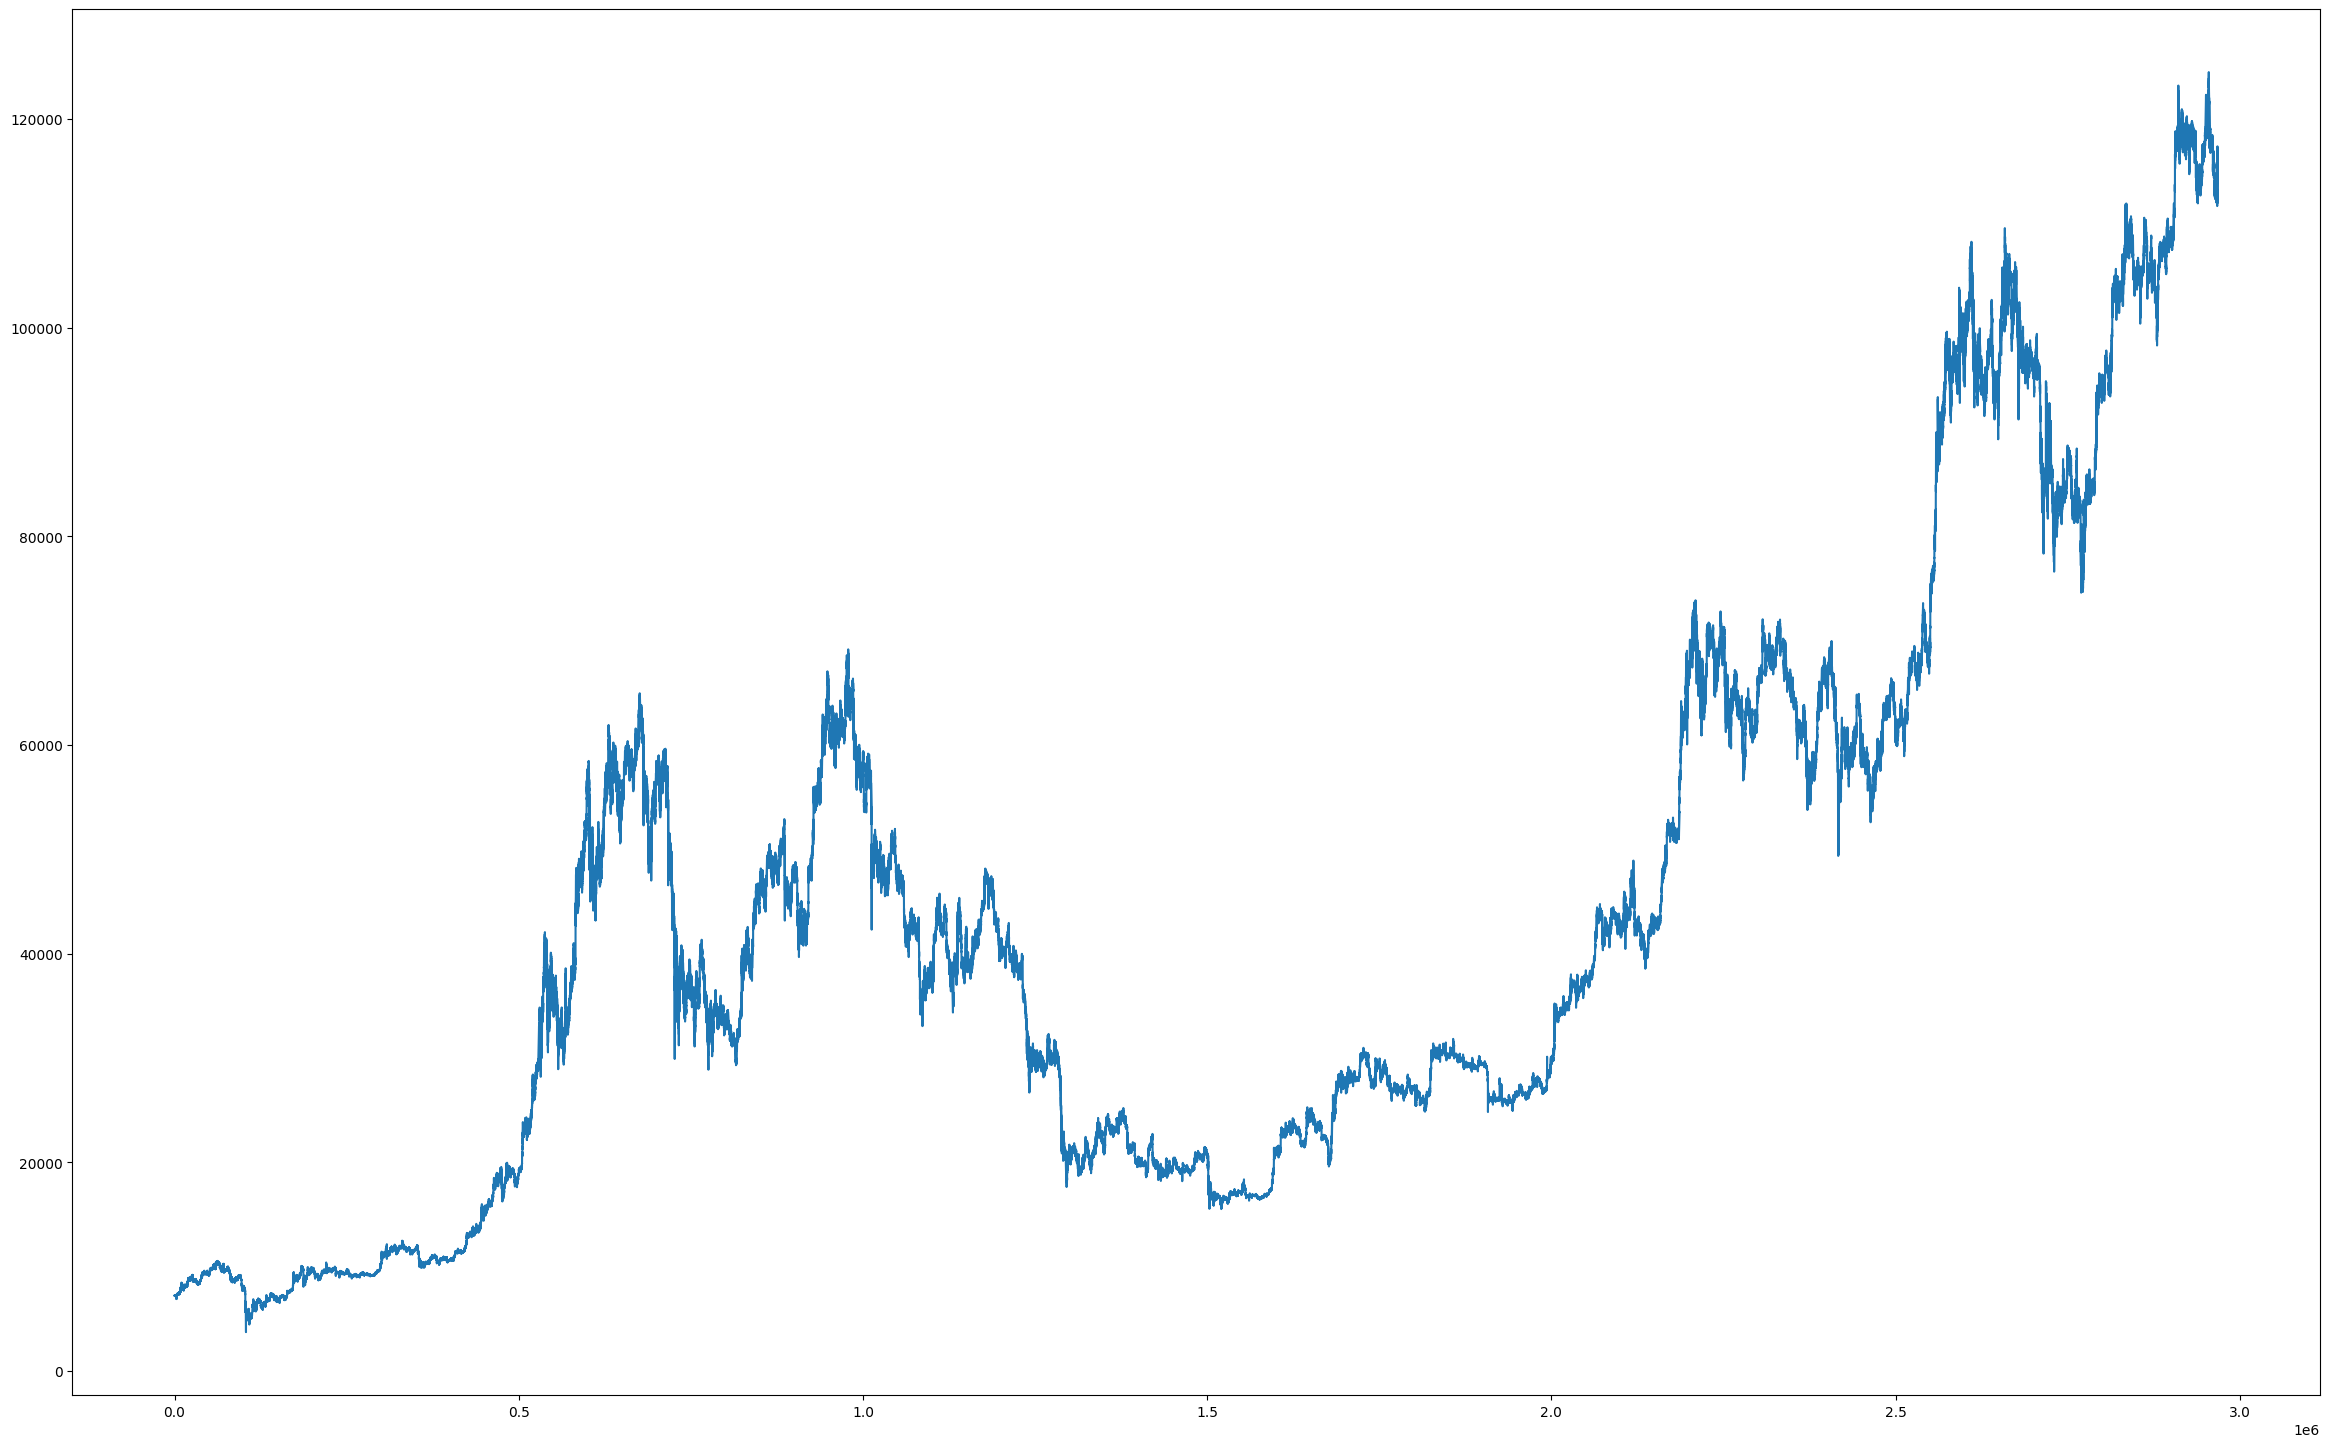

In [4]:
plt.plot(hlcv[:,2])

In [5]:
# Calculate ADX
df = pd.DataFrame(hlcv, columns=["high", "low", "close", "volume"])
df["adx"] = ta.trend.adx(df["high"], df["low"], df["close"], window=30)
df["adx"].fillna(method="bfill", inplace=True)
adx = df["adx"].values

In [6]:
results = {(0.01632, 1.518, 51.54, 0.02986, 0.02407, 0.005983, 0.01054, 1.3, 0.7, 10): None}
eligible = {}

In [7]:
len(eligible)

0

In [8]:
def perform_backtest(hlcv, adx, key):
    (
        initial_qty_pct,
        double_down_factor,
        wallet_exposure_limit,
        trailing_threshold_pct_profit,
        trailing_threshold_pct_loss,
        trailing_retracement_pct_profit,
        trailing_retracement_pct_loss,
        adx_scale_higher_width,
        adx_scale_lower_width,
        max_flips_per_cycle,
    ) = key
    fee_rate = 0.00055
    fills, equities = pbr.backtest_trailing_flip(
        hlcv,
        adx,
        initial_qty_pct,
        double_down_factor,
        wallet_exposure_limit,
        trailing_threshold_pct_profit,
        trailing_retracement_pct_profit,
        trailing_threshold_pct_loss,
        trailing_retracement_pct_loss,
        fee_rate,
        adx_scale_higher_width,
        adx_scale_lower_width,
        int(max_flips_per_cycle),  # Ensure int
    )
    fdf = pd.DataFrame(fills, columns=["index", "pnl", "fee_paid", "balance", "qty", "price", "psize", "pprice", "upnl", "type"]).set_index('index')
    edf = pd.Series(equities)
    fdf.loc[:,'wallet_exposure'] = fdf.psize.abs() * fdf.pprice / fdf.balance
    fdf.loc[:,'equity'] = fdf.balance + fdf.upnl
    drawdowns = calc_drawdowns(edf)
    drawdown_worst = abs(drawdowns.min())
    gain = edf.iloc[-1] / edf.iloc[0]
    n_days = len(edf) / 60 / 24
    adg = gain ** (1 / n_days) - 1 if gain > 0.0 else gain
    return {'drawdown_worst': drawdown_worst, 'adg': adg}

In [9]:
begin_harmony_search = 20
harmony_memory_size = 20
limit_drawdown_worst = 0.25
n_iters = 50000

for k in results:
    if results[k] is None:
        results[k] = perform_backtest(hlcv, adx, k)
        print('backtested', k, results[k])
        
eligible = {k: v for k, v in results.items() if v and v['drawdown_worst'] < limit_drawdown_worst}
for z in range(n_iters):
    if len(eligible) > begin_harmony_search:
        mode = 'harmony_search'
        resfs = sorted(eligible.items(), key=lambda x: x[1]['adg'])[-harmony_memory_size:]
        candidate = []
        for i in range(len(resfs[0][0])):
            vals = [resfs[k][0][i] for k in range(len(resfs))]
            candidate.append((np.random.choice(vals) + np.random.uniform(-0.000001, 0.000001)) * np.random.uniform(0.9, 1.1))
        # Clamp max_flips_per_cycle to [5, 12]
        candidate[-1] = int(np.clip(round(candidate[-1]), 5, 12))
    else:
        mode = 'random'
        initial_qty_pct = np.random.uniform(0.01, 1.0)
        double_down_factor = np.random.uniform(1.1, 3.0)
        wallet_exposure_limit = np.random.uniform(10.0, 100.0)
        trailing_threshold_pct_profit = np.random.uniform(0.01, 0.03)
        trailing_threshold_pct_loss = np.random.uniform(0.01, 0.03)
        trailing_retracement_pct_profit = np.random.uniform(0.00001, 0.01)
        trailing_retracement_pct_loss = np.random.uniform(0.00001, 0.01)
        adx_scale_higher_width = np.random.uniform(1.0, 3.0)
        adx_scale_lower_width = np.random.uniform(0.5, 1.0)
        max_flips_per_cycle = int(np.random.randint(4, 13))

        candidate = [
            initial_qty_pct,
            double_down_factor,
            wallet_exposure_limit,
            trailing_threshold_pct_profit,
            trailing_threshold_pct_loss,
            trailing_retracement_pct_profit,
            trailing_retracement_pct_loss,
            adx_scale_higher_width,
            adx_scale_lower_width,
            max_flips_per_cycle,
        ]
        
    key = (
        pbr.round_dynamic(candidate[0], 4),
        pbr.round_dynamic(candidate[1], 4),
        pbr.round_dynamic(candidate[2], 4),
        pbr.round_dynamic(candidate[3], 4),
        pbr.round_dynamic(candidate[4], 4),
        pbr.round_dynamic(candidate[5], 4),
        pbr.round_dynamic(candidate[6], 4),
        pbr.round_dynamic(candidate[7], 4),
        pbr.round_dynamic(candidate[8], 4),
        int(candidate[9]),  # Ensure int
    )
    if key in results:
        continue
    result = perform_backtest(hlcv, adx, key)
    results[key] = result
    if result['drawdown_worst'] < limit_drawdown_worst:
        eligible[key] = result
        print(z, len(eligible), mode, key, eligible[key])
        

backtested (0.01632, 1.518, 51.54, 0.02986, 0.02407, 0.005983, 0.01054, 1.3, 0.7, 10) {'drawdown_worst': 0.2178858941987215, 'adg': -9.572956802261778e-05}
173 2 random (0.0555, 1.646, 85.68, 0.01187, 0.02301, 0.0002764, 0.004803, 1.22, 0.9646, 4) {'drawdown_worst': 0.24205513016178049, 'adg': -9.787432963503928e-05}
188 3 random (0.01624, 1.331, 60.02, 0.01193, 0.02545, 0.002513, 0.009297, 1.7, 0.7327, 8) {'drawdown_worst': 0.09200251877318877, 'adg': -3.860016983847636e-05}
215 4 random (0.01955, 1.97, 54.24, 0.02172, 0.02354, 0.00498, 0.003665, 2.478, 0.7005, 4) {'drawdown_worst': 0.20578239067145354, 'adg': -8.393714053067658e-05}
216 5 random (0.03521, 1.543, 57.88, 0.01591, 0.02631, 0.006482, 0.005885, 1.816, 0.9207, 9) {'drawdown_worst': 0.09916558001545502, 'adg': -3.817042666331982e-05}
269 6 random (0.01679, 1.166, 33.46, 0.0102, 0.01309, 0.00446, 0.005733, 2.386, 0.8539, 4) {'drawdown_worst': 0.14951307541009037, 'adg': -7.563770214247256e-05}
346 7 random (0.02699, 1.153, 1

In [10]:
resf = {k: v for k, v in results.items() if v['drawdown_worst'] < limit_drawdown_worst}
resfs = sorted(resf.items(), key=lambda x: x[1]['adg'])[-harmony_memory_size:]
resfs

[((0.01271,
   2.529,
   78.75,
   0.02497,
   0.02375,
   0.008533,
   0.009825,
   0.8142,
   0.6932,
   11),
  {'drawdown_worst': 0.24935564619237088, 'adg': 0.0006316541844102463}),
 ((0.01062,
   2.601,
   96.01,
   0.02774,
   0.02671,
   0.005822,
   0.01051,
   0.9014,
   0.6529,
   11),
  {'drawdown_worst': 0.21936841503231652, 'adg': 0.0006316587005974483}),
 ((0.008871,
   2.979,
   68.81,
   0.0276,
   0.03385,
   0.007764,
   0.009304,
   0.8274,
   0.6052,
   10),
  {'drawdown_worst': 0.2333070416095775, 'adg': 0.0006344247623462085}),
 ((0.01419,
   2.56,
   85.25,
   0.02537,
   0.02515,
   0.006646,
   0.009247,
   0.8231,
   0.7106,
   11),
  {'drawdown_worst': 0.2071347388649123, 'adg': 0.0006363181218858038}),
 ((0.01538,
   2.394,
   80.96,
   0.02422,
   0.02425,
   0.00667,
   0.005414,
   1.612,
   0.6788,
   11),
  {'drawdown_worst': 0.21615057286017747, 'adg': 0.0006419942466504569}),
 ((0.01303,
   2.669,
   88.28,
   0.02701,
   0.03165,
   0.007915,
   0.00

In [23]:
if not resfs:
    print("No eligible candidates found.")
    # Skip further processing
    raise ValueError("No eligible candidates found. Adjust parameters or increase iterations.")

candidate = resfs[-1][0]
fee_rate = 0.00055
nitial_qty_pct, double_down_factor, wallet_exposure_limit, trailing_threshold_pct_profit, trailing_threshold_pct_loss, trailing_retracement_pct_profit, trailing_retracement_pct_loss, adx_scale_higher_width, adx_scale_lower_width, max_flips_per_cycle = candidate
fills, equities = pbr.backtest_trailing_flip(
    hlcv,
    adx,
    initial_qty_pct,
    double_down_factor,
    wallet_exposure_limit,
    trailing_threshold_pct_profit,
    trailing_retracement_pct_profit,
    trailing_threshold_pct_loss,
    trailing_retracement_pct_loss,
    fee_rate,
    adx_scale_higher_width,
    adx_scale_lower_width,
    int(max_flips_per_cycle),  # Ensure int
)
fdf = pd.DataFrame(fills, columns=["index", "pnl", "fee_paid", "balance", "qty", "price", "psize", "pprice", "upnl", "type"]).set_index('index')
edf = pd.Series(equities)
fdf.loc[:,'wallet_exposure'] = fdf.psize.abs() * fdf.pprice / fdf.balance
fdf.loc[:,'equity'] = fdf.balance + fdf.upnl
drawdowns = calc_drawdowns(edf)
drawdown_worst = abs(drawdowns.min())
gain = edf.iloc[-1] / edf.iloc[0]
n_days = len(edf) / 60 / 24
adg = gain ** (1 / n_days) - 1
print('drawdown_worst', drawdown_worst)
print('n_days', n_days)
print('n fills', len(fdf))
print('adg', adg)
print('gain', gain)
print('WE max', fdf.wallet_exposure.max())

param_names = [
    "initial_qty_pct",
    "double_down_factor",
    "wallet_exposure_limit",
    "trailing_threshold_pct_profit",
    "trailing_threshold_pct_loss",
    "trailing_retracement_pct_profit",
    "trailing_retracement_pct_loss",
    "adx_scale_higher_width",
    "adx_scale_lower_width",
    "max_flips_per_cycle",
]
print()
for name, value in zip(param_names, candidate):
    print(f"{name}: {value}")

drawdown_worst 0.24798341703947616
n_days 2061.0006944444444
n fills 7967
adg 0.0008374465189435742
gain 5.613955511031817
WE max 12.799145781711372

initial_qty_pct: 0.01468
double_down_factor: 2.993
wallet_exposure_limit: 59.93
trailing_threshold_pct_profit: 0.02407
trailing_threshold_pct_loss: 0.02836
trailing_retracement_pct_profit: 0.005429
trailing_retracement_pct_loss: 0.009959
adx_scale_higher_width: 0.9487
adx_scale_lower_width: 0.6868
max_flips_per_cycle: 10


<AxesSubplot:>

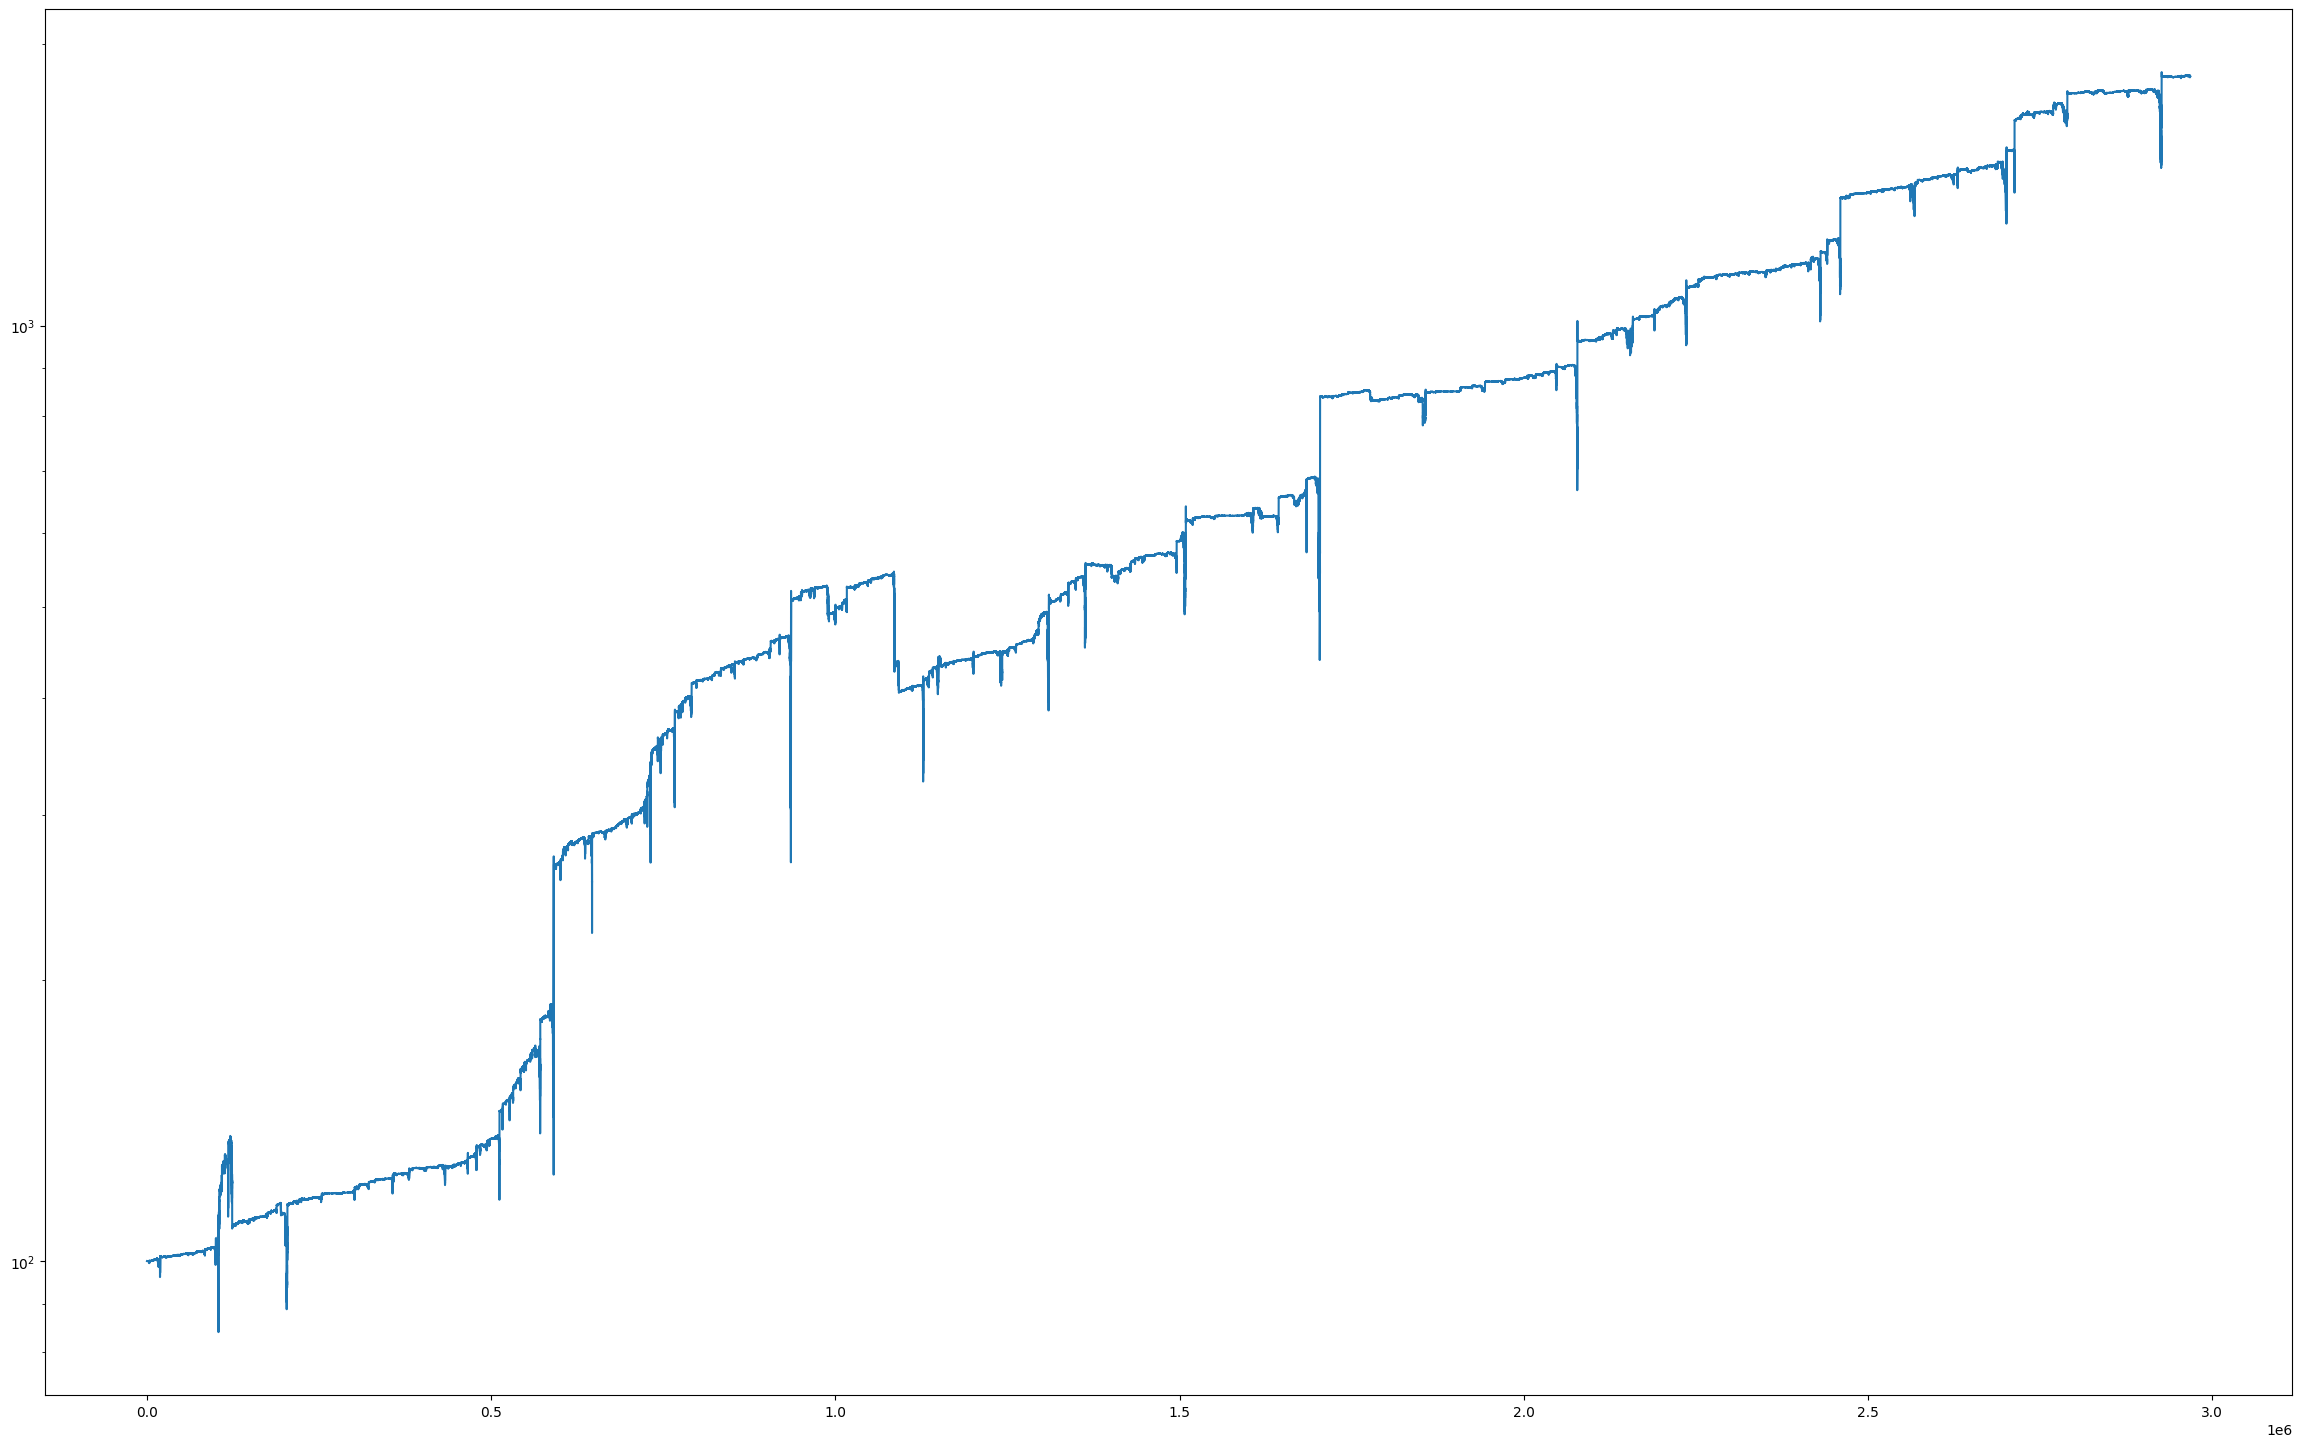

In [12]:
edf.plot(logy=True)

<AxesSubplot:>

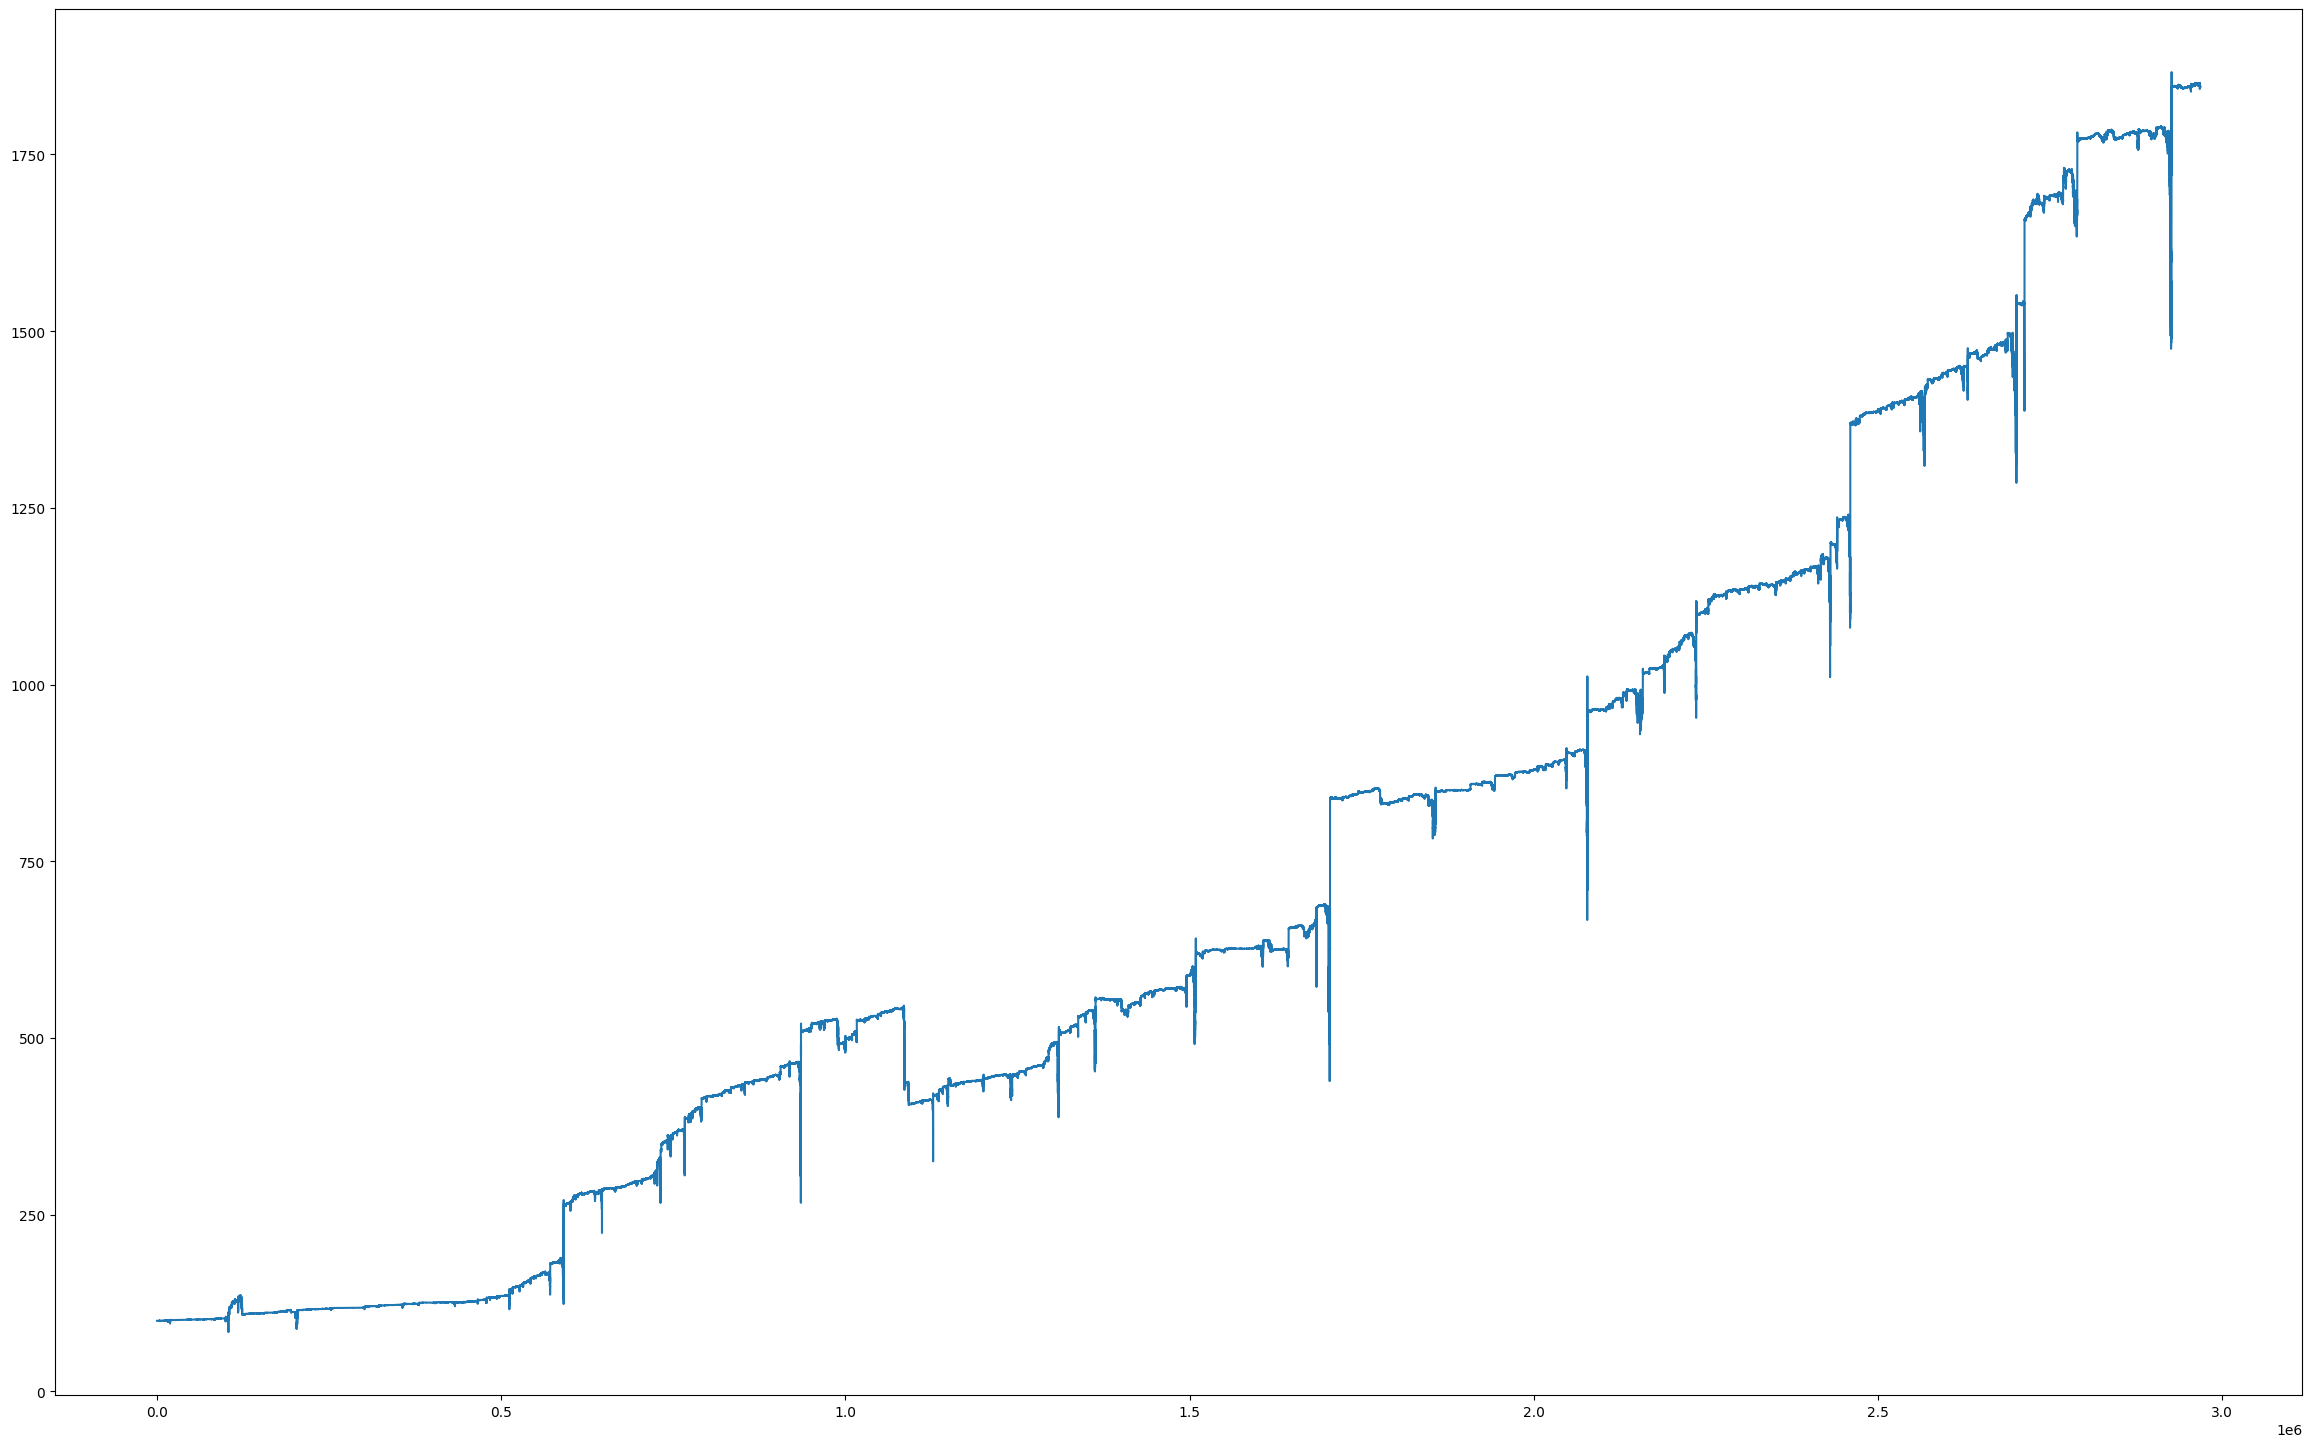

In [13]:
edf.plot(logy=False)

In [14]:
cost_pct = (fdf.qty.abs() * fdf.price) / fdf.balance
cost_pct.groupby(cost_pct.index // 1440).sum().mean()

1.003071959858929

In [15]:
fdf.iloc[:60]

,pnl,fee_paid,balance,qty,price,psize,pprice,upnl,type,wallet_exposure,equity
index,,,,,,,,,,,
1,0.000000,0.001399,99.998601,0.000354,7182.44,0.000354,7182.44,-0.001307,entry_long,0.025432,99.997295
2565,-0.072933,0.001359,99.924310,-0.000354,6976.46,0.000000,0.00,0.000000,close_long,0.000000,99.924310
2565,0.000000,0.004066,99.920243,-0.001060,6976.46,-0.001060,6976.46,-0.001240,entry_short,0.073992,99.919003
3166,-0.235350,0.004196,99.680697,0.001060,7198.54,0.000000,0.00,0.000000,close_short,0.000000,99.680697
3166,0.000000,0.012558,99.668139,0.003172,7198.54,0.003172,7198.54,-0.159861,entry_long,0.229087,99.508278
3545,0.385569,0.012770,100.040939,-0.003172,7320.10,0.000000,0.00,0.000000,close_long,0.000000,100.040939
3546,0.000000,0.001399,100.039540,0.000347,7331.44,0.000347,7331.44,-0.001742,entry_long,0.025432,100.037798
5846,0.042944,0.001423,100.081061,-0.000347,7455.19,0.000000,0.00,0.000000,close_long,0.000000,100.081061
5847,0.000000,0.001400,100.079661,0.000341,7453.78,0.000341,7453.78,-0.011535,entry_long,0.025432,100.068126


In [16]:
exchange_min_order = 5

candidate = resfs[-1][0]
fee_rate = 0.00055
initial_qty_pct, double_down_factor, wallet_exposure_limit, trailing_threshold_pct_profit, trailing_threshold_pct_loss, trailing_retracement_pct_profit, trailing_retracement_pct_loss, adx_scale_higher_width, adx_scale_lower_width, max_flips_per_cycle = candidate

# Convert wallet_exposure_limit from percentage to decimal
wallet_exposure_limit /= 100 

# Calculate the total required balance for max flips
total_order_size = 0
for i in range(max_flips_per_cycle):
    total_order_size += exchange_min_order * (double_down_factor ** i)

# Adjust for wallet exposure limit
required_balance = total_order_size / wallet_exposure_limit

print(f"Minimum starting balance needed: {required_balance:.2f}")

Minimum starting balance needed: 241478.28


In [17]:
fdf.sort_values('wallet_exposure')

,pnl,fee_paid,balance,qty,price,psize,pprice,upnl,type,wallet_exposure,equity
index,,,,,,,,,,,
911417,1.778518,0.058253,460.738323,-0.002466,42942.13,0.000000,0.00,0.000000,close_long,0.000000,460.738323
749142,6.838388,0.130718,365.523984,0.006472,36723.38,0.000000,0.00,0.000000,close_short,0.000000,365.523984
748974,-1.975990,0.044931,358.950794,-0.002162,37780.01,0.000000,0.00,0.000000,close_long,0.000000,358.950794
2187861,0.625029,0.014666,1024.542295,-0.000455,58601.50,0.000000,0.00,0.000000,close_long,0.000000,1024.542295
747792,-0.952557,0.015375,361.017733,0.000722,38693.83,0.000000,0.00,0.000000,close_short,0.000000,361.017733
...,...,...,...,...,...,...,...,...,...,...,...
646362,0.000000,0.904246,245.714440,-0.030610,53711.35,-0.030610,53711.35,-0.264773,entry_short,6.691037,245.449667
590527,0.000000,1.877939,150.100834,0.071628,47669.18,0.071628,47669.18,-1.015681,entry_long,22.747609,149.085153
2077517,0.000000,8.765338,692.474008,0.379839,41957.20,0.379839,41957.20,-9.609925,entry_long,23.014551,682.864083


<AxesSubplot:xlabel='index'>

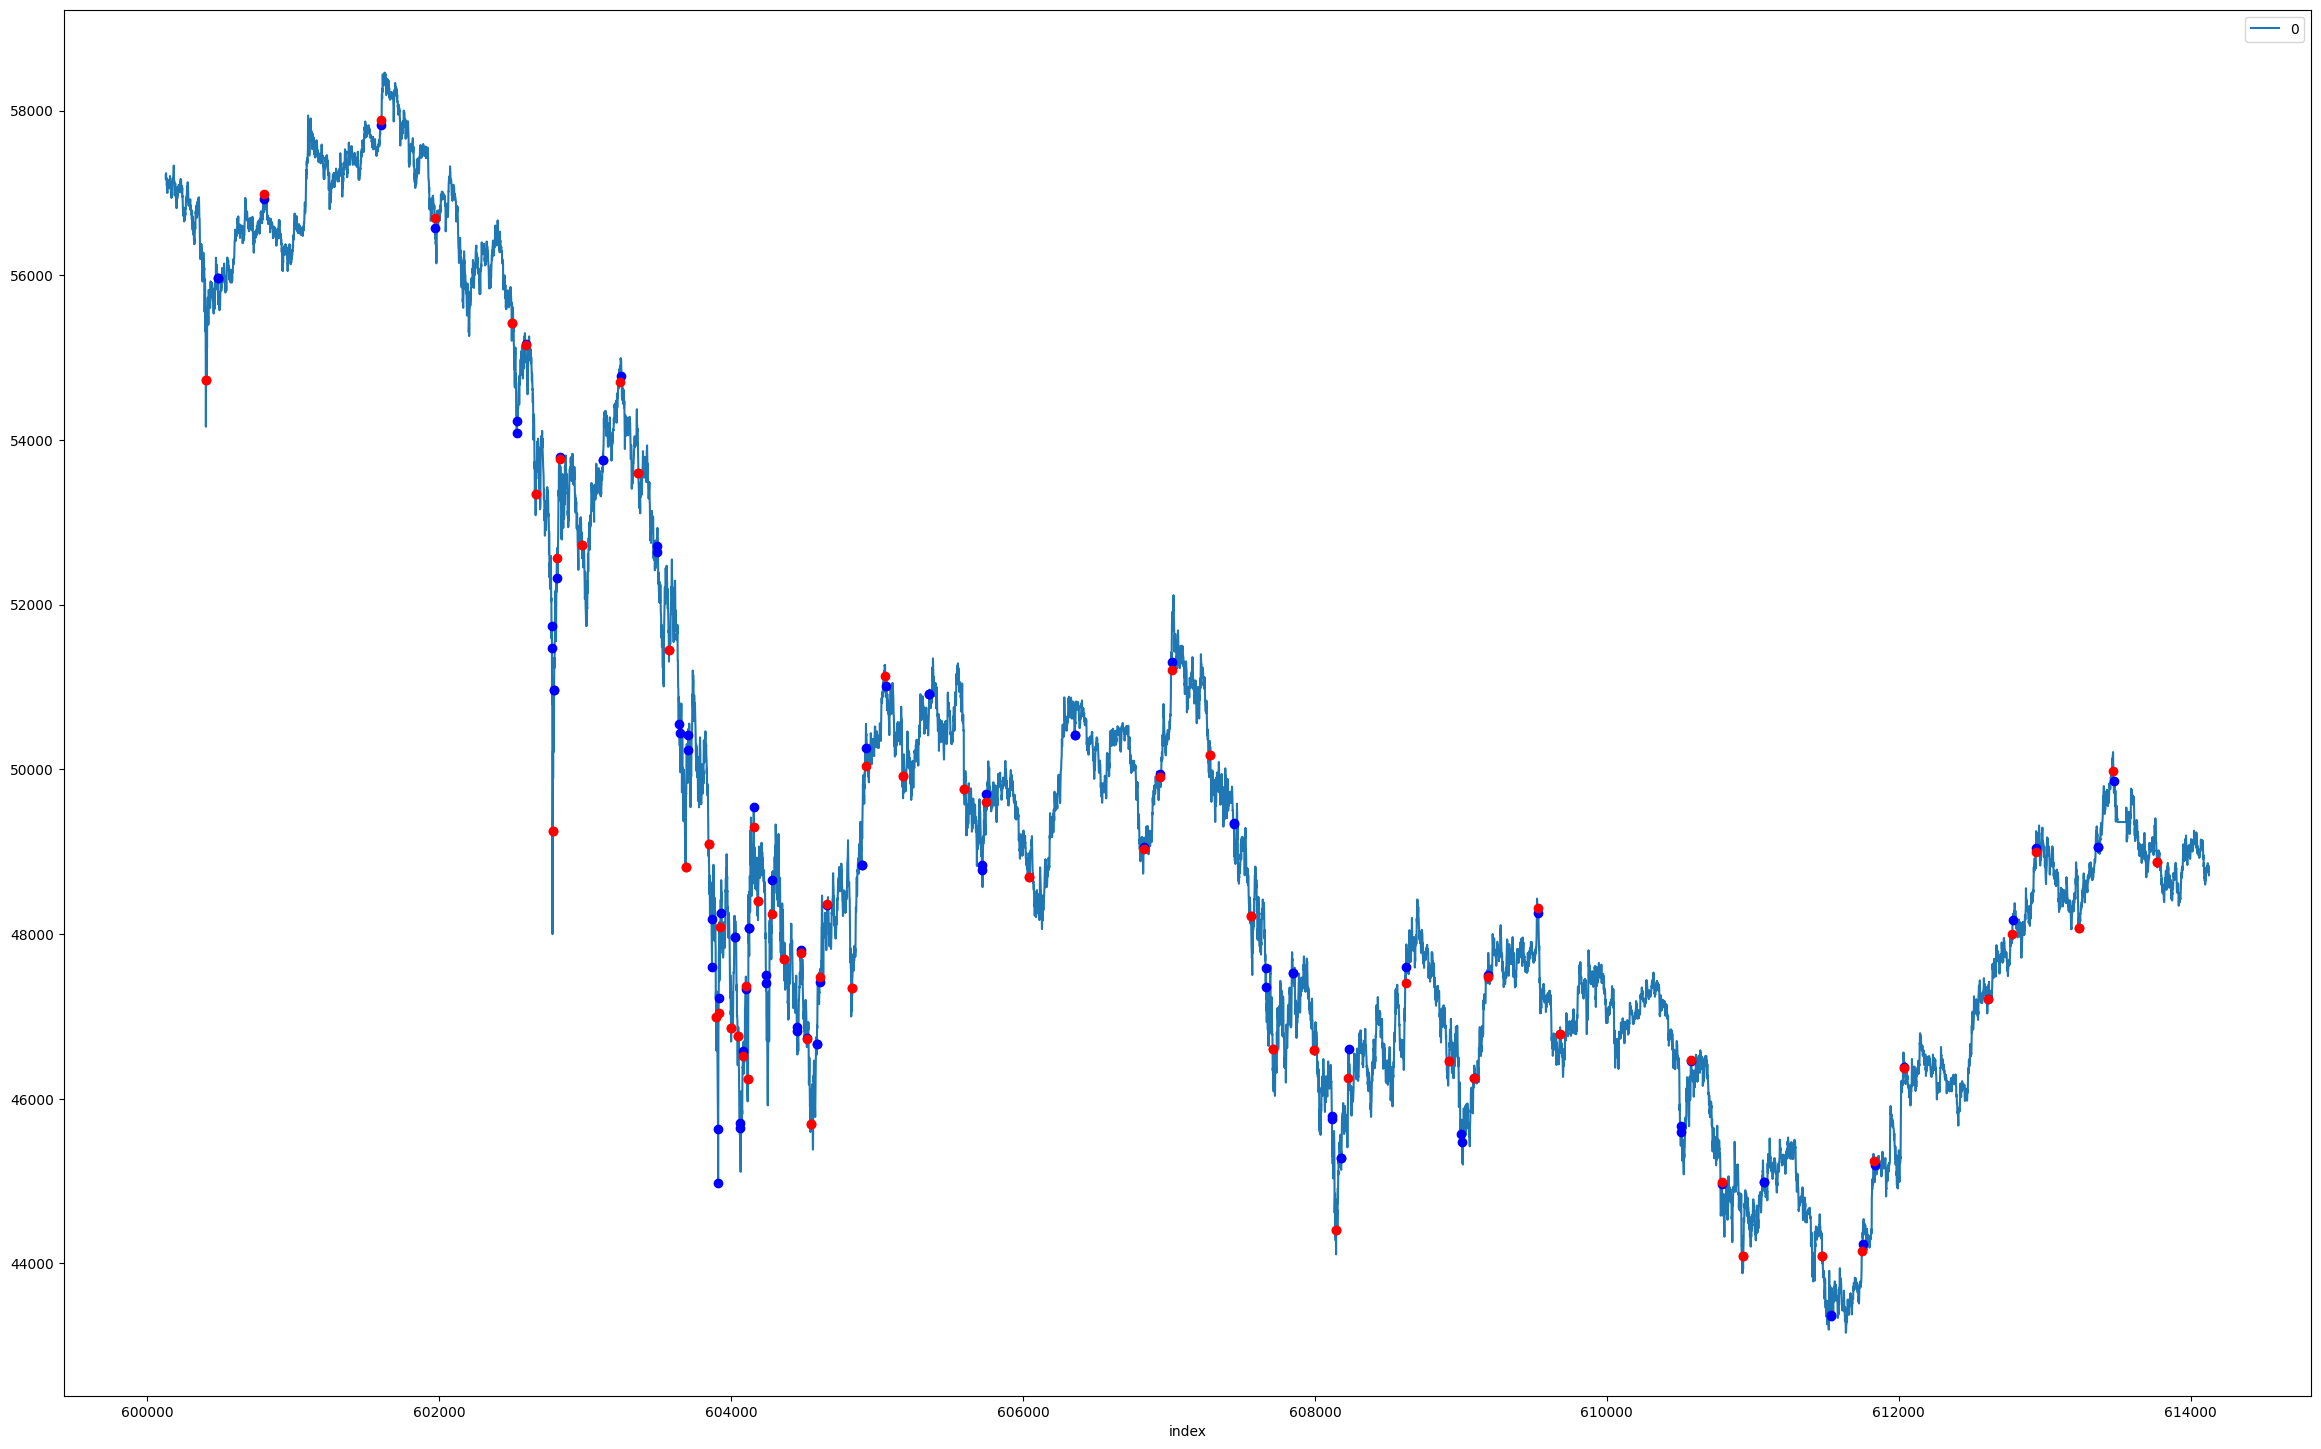

In [18]:
i = 607126
n = 7000
fdfc = fdf.loc[i-n:i+n]
buys = fdfc[fdfc.qty > 0.0]
sells = fdfc[fdfc.qty < 0.0]
pd.DataFrame(hlcv[:,2]).loc[i-n:i+n].plot()
buys.price.plot(style='bo')
sells.price.plot(style='ro')

In [19]:
fdfc

,pnl,fee_paid,balance,qty,price,psize,pprice,upnl,type,wallet_exposure,equity
index,,,,,,,,,,,
600403,-2.564495,0.032345,263.735087,-0.001075,54728.22,0.000000,0.00,0.000000,close_long,0.000000,263.735087
600403,0.000000,0.096809,263.638278,-0.003216,54728.22,-0.003216,54728.22,-0.533180,entry_short,0.667643,263.105098
600481,-3.975404,0.098995,259.563878,0.003216,55964.28,0.000000,0.00,0.000000,close_short,0.000000,259.563878
600481,0.000000,0.296293,259.267585,0.009626,55964.28,0.009626,55964.28,-2.361946,entry_long,2.077835,256.905639
600796,9.825509,0.301697,268.791397,-0.009626,56985.00,0.000000,0.00,0.000000,close_long,0.000000,268.791397
...,...,...,...,...,...,...,...,...,...,...,...
613369,0.000000,0.035003,278.637352,0.001297,49058.27,0.001297,49058.27,-0.031239,entry_long,0.228406,278.606113
613472,1.189415,0.035658,279.791109,-0.001297,49975.12,0.000000,0.00,0.000000,close_long,0.000000,279.791109
613473,0.000000,0.003914,279.787195,0.000143,49863.04,0.000143,49863.04,-0.023264,entry_long,0.025432,279.763931


<AxesSubplot:>

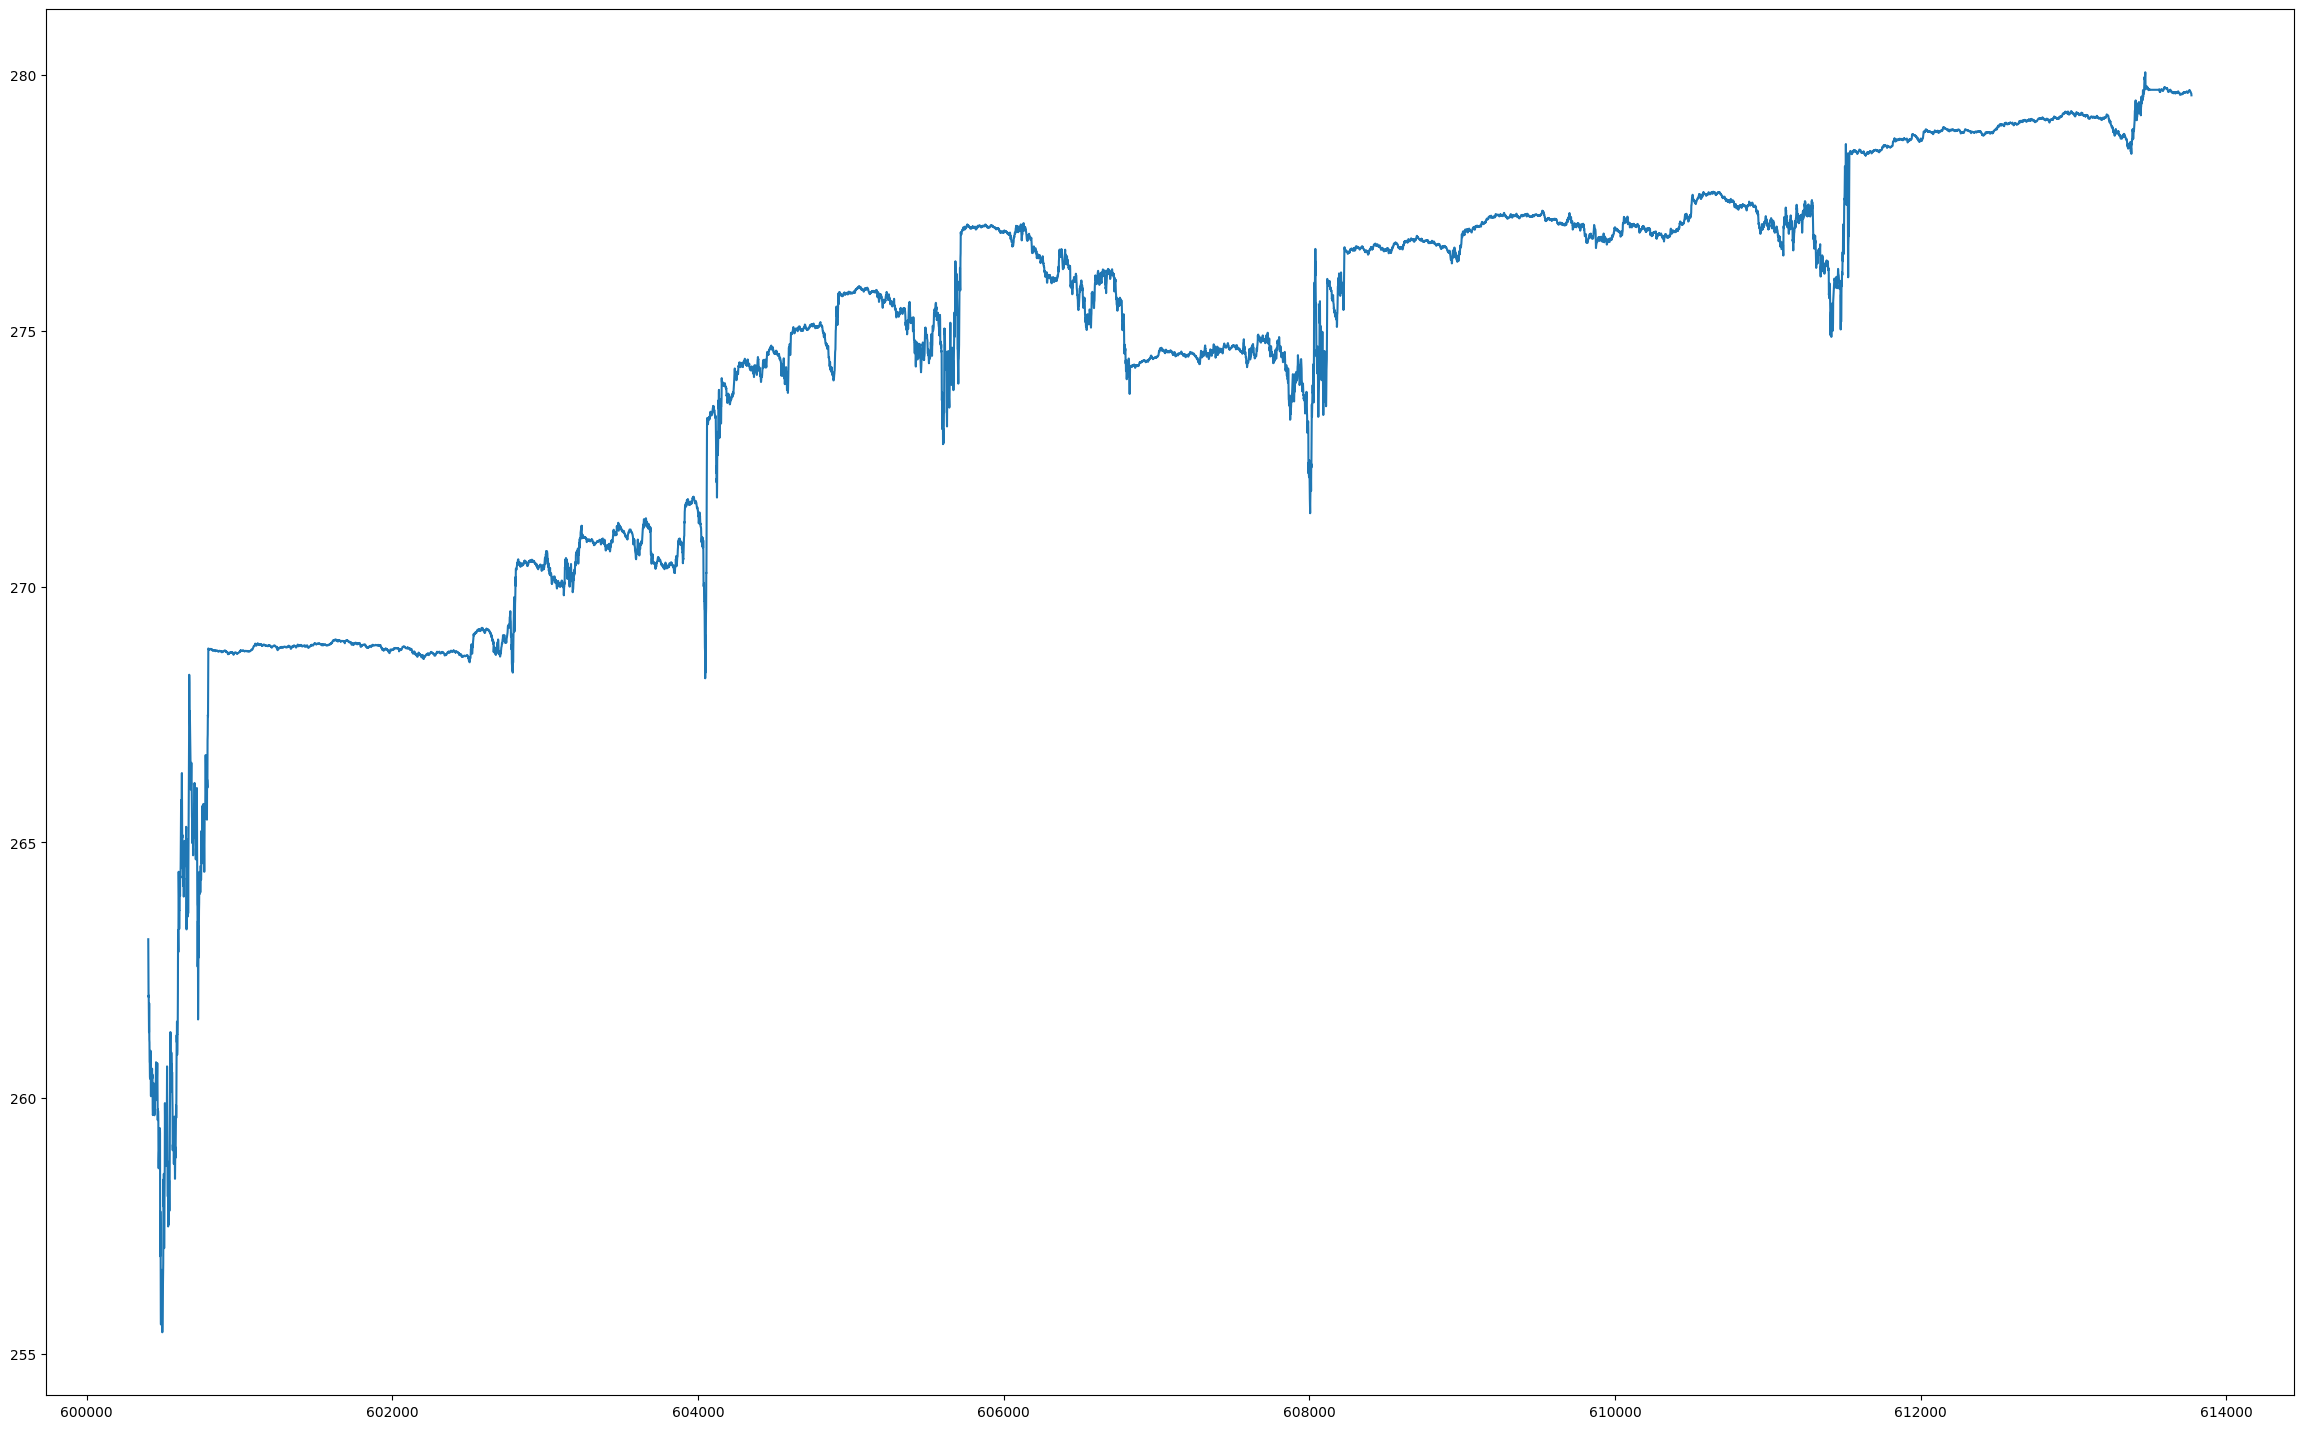

In [20]:
edf.loc[fdfc.index[0]:fdfc.index[-1]].plot()

In [21]:
fdf.sort_values('wallet_exposure').iloc[-10:]

,pnl,fee_paid,balance,qty,price,psize,pprice,upnl,type,wallet_exposure,equity
index,,,,,,,,,,,
1308409,0.0,1.606919,448.686642,-0.140698,20765.60,-0.140698,20765.60,-2.208953,entry_short,6.511608,446.477689
2430147,0.0,3.856448,1074.329046,-0.118300,59270.50,-0.118300,59270.50,-7.890636,entry_short,6.526606,1066.438410
1085504,0.0,1.803583,501.980441,-0.094335,34761.57,-0.094335,34761.57,-0.523561,entry_short,6.532608,501.456880
511819,0.0,0.436269,120.295284,-0.034736,22835.33,-0.034736,22835.33,-1.204310,entry_short,6.593912,119.090974
765831,0.0,1.229430,336.438374,-0.055961,39944.27,-0.055961,39944.27,-2.670466,entry_short,6.644092,333.767908
646362,0.0,0.904246,245.714440,-0.030610,53711.35,-0.030610,53711.35,-0.264773,entry_short,6.691037,245.449667
590527,0.0,1.877939,150.100834,0.071628,47669.18,0.071628,47669.18,-1.015681,entry_long,22.747609,149.085153
2077517,0.0,8.765338,692.474008,0.379839,41957.20,0.379839,41957.20,-9.609925,entry_long,23.014551,682.864083
1703265,0.0,6.728844,530.270054,0.448416,27283.30,0.448416,27283.30,-14.932246,entry_long,23.071758,515.337808
